In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import deepsurv_tf
import numpy
import deepsurv
import seaborn as sns
import pandas

/home/icarus/.conda/envs/py27/lib/python2.7/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


### Generate data

In [2]:
def generate_data(treatment_group = False):
    numpy.random.seed(123)
    sd = deepsurv.datasets.SimulatedData(5, num_features = 9,
        treatment_group = treatment_group)
    train_data = sd.generate_data(5000)
    valid_data = sd.generate_data(2000)
    test_data = sd.generate_data(2000)
    return train_data, valid_data, test_data

train, valid, test = generate_data(treatment_group=True)

[ 1.  0.  1. ...,  1.  0.  0.]
[ 1.  1.  1. ...,  1.  1.  1.]
[ 0.  1.  1. ...,  1.  0.  1.]


In [3]:
epochs= 5000

#### Run model

In [4]:
params = deepsurv_tf.Parameters()
params.n_in = train['x'].shape[1]
params.n_epochs = epochs

ds_tf = deepsurv_tf.DeepSurvTF(params)
stats = ds_tf.train(train, valid)

stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
stats = pandas.melt(stats, id_vars=["epochs","type"])

Training done
Best epoch 110
Best loss 12751.0


#### Loss is the negative likelihood, and ci is the concordance index

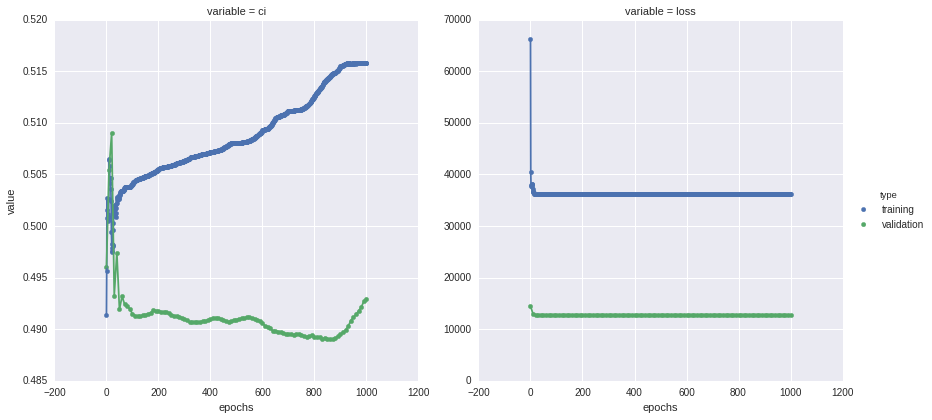

In [5]:
sns.FacetGrid(data= stats,hue = "type", col="variable", sharey=False, size = 6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

#### Run deepsurv

In [6]:
hyperparams = {
    'n_in': 10,
    'learning_rate': 1e-5,
    'hidden_layers_sizes': [10,10]
}

network = deepsurv.DeepSurv(**hyperparams)
network.restored_update_params = False
log = network.train(train, valid, n_epochs=epochs)


[INFO] Training CoxMLP
Finished Training with 1001 iterations in 128.83s


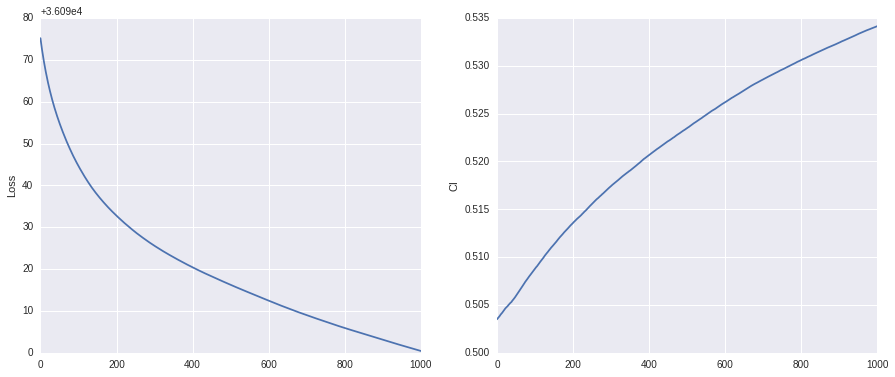

In [7]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (15,6))
ax1.plot(log["train"], label = "training loss")
ax1.set_ylabel("Loss")
ax2.set_ylabel("CI")
ax2.plot(log["train_ci"], label = "training ci")


### Effect of configurations

#### Different hidden layers

a
Training done
Best epoch 4960
Best loss 12739.6
c
Training done
Best epoch 20
Best loss 12748.8
b
Training done
Best epoch 60
Best loss 12752.8
d
Training done
Best epoch 60
Best loss 12748.8


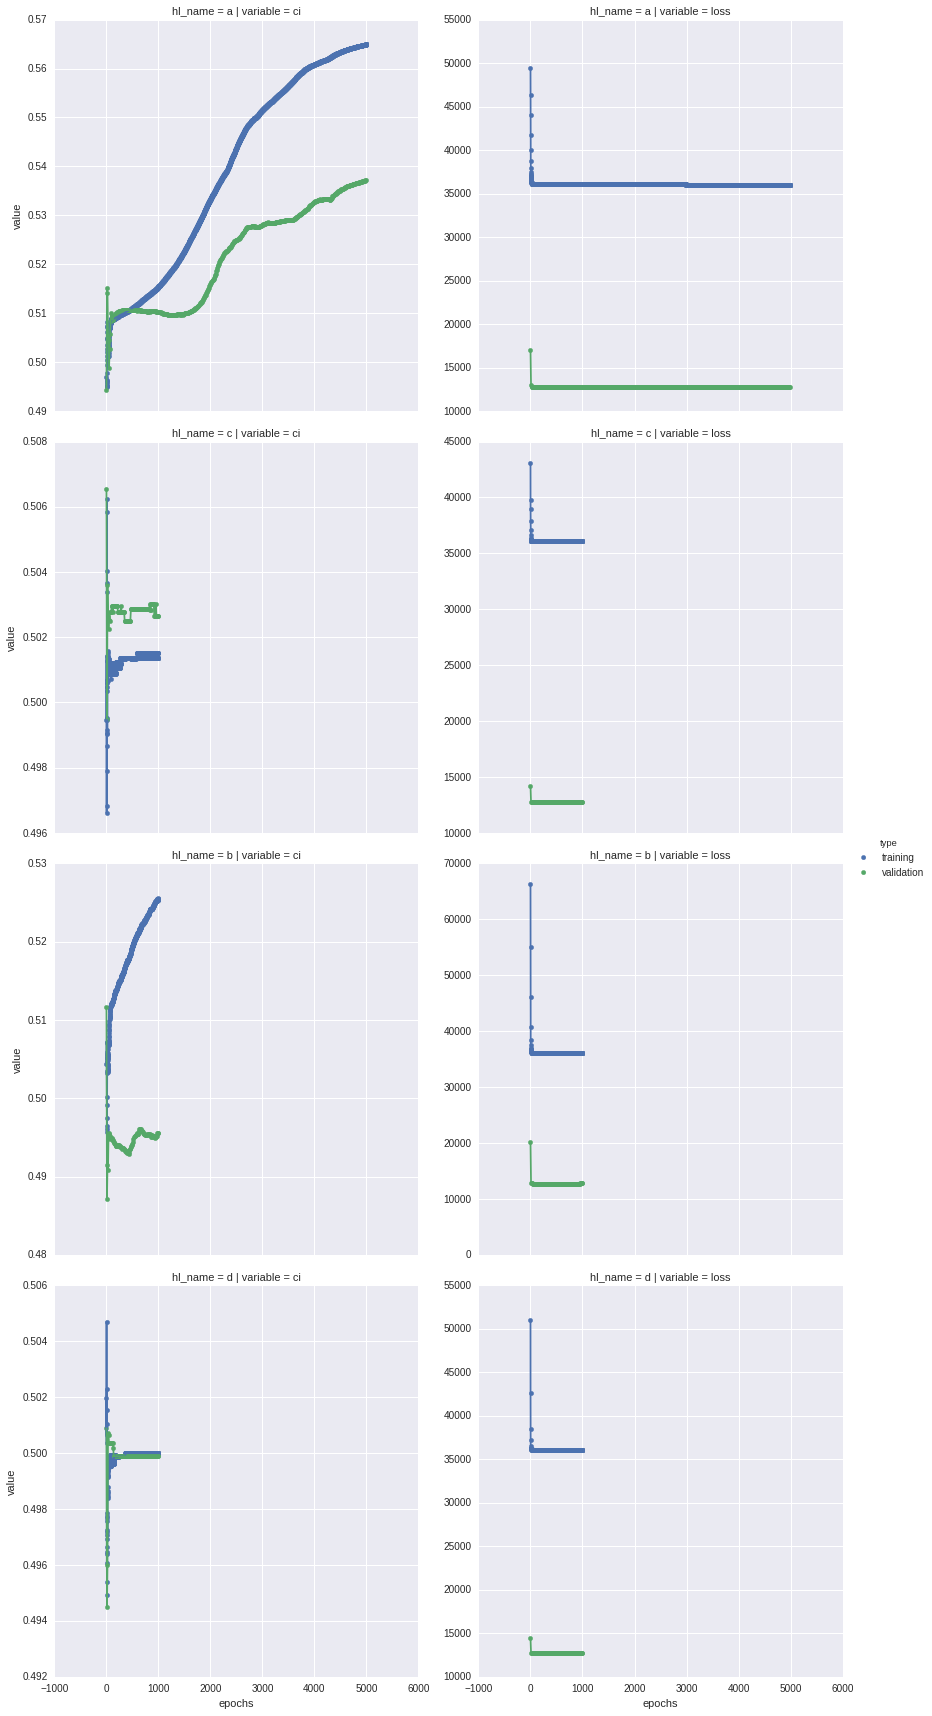

In [8]:
hidden_layers = {
    "a": [10], 
    "b": [10]*2,##repeat 10, 2 times
    "c": [5]*4,##repeat 5, 10 times
    "d": [10,5,8,3]
}

all_stats = []
for name, hl in hidden_layers.items():
    print name
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.hidden_layers_sizes = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, size = 6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

#### Different L2 regularisations

a
Training done
Best epoch 80
Best loss 12766.2
c
Training done
Best epoch 470
Best loss 12748.8
b
Training done
Best epoch 110
Best loss 12748.4


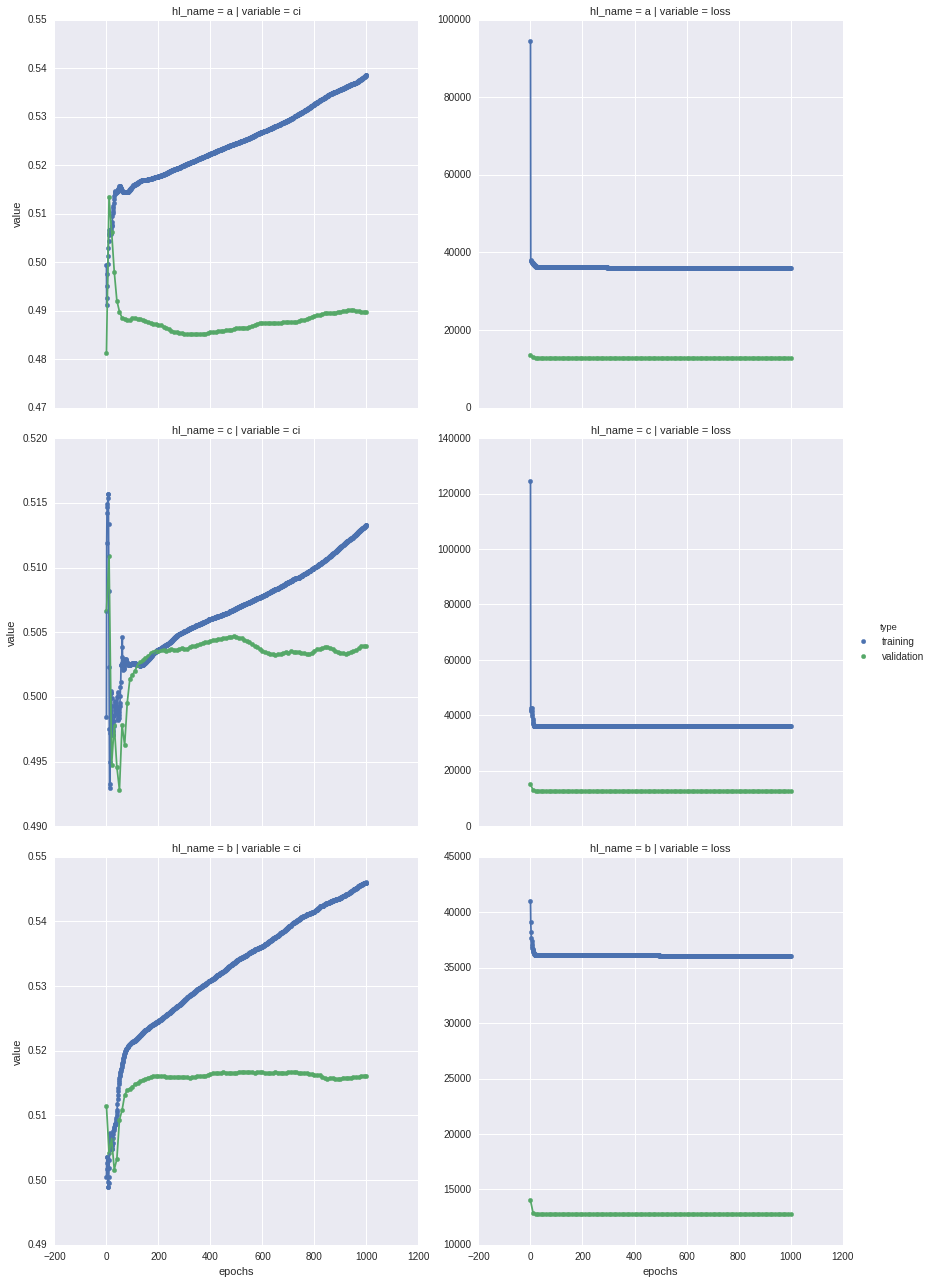

In [9]:
regularisations = {
    "a":0.1,
    "b":0.01,
    "c":0.001
}

all_stats = []
for name, hl in regularisations.items():
    print name
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.L2_reg = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, size = 6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

#### drop out

a
Training done
Best epoch 200
Best loss 12750.6
c
Training done
Best epoch 100
Best loss 12752.0
b
Training done
Best epoch 500
Best loss 12741.4


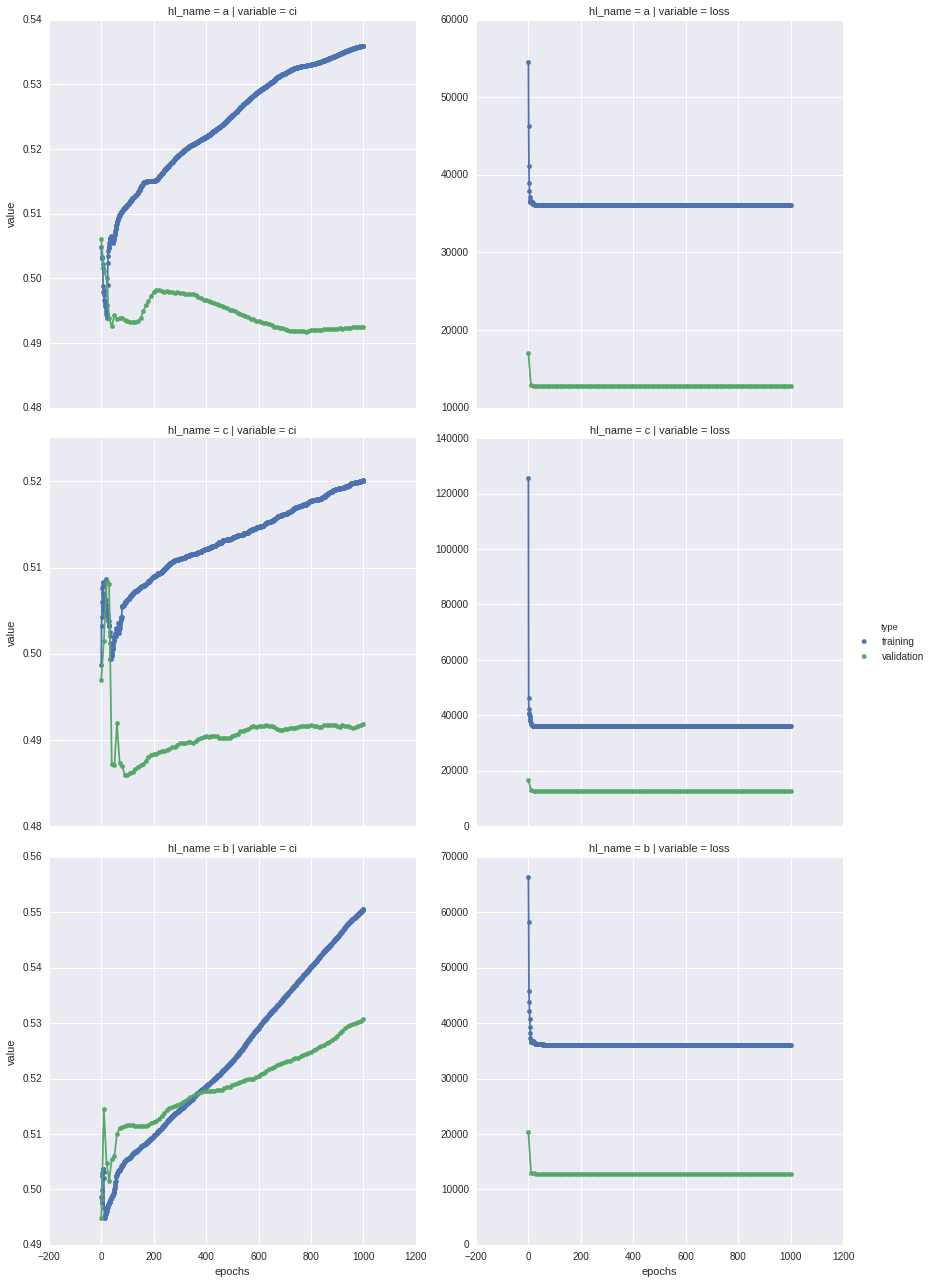

In [10]:
drop_out = {
    "a": None,
    "b": 0.4,
    "c": 0.8
}

all_stats = []
for name, hl in drop_out.items():
    print name
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.L2_reg = 0 #switching off other regularisations
    params.drop_out = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, size = 6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()

#### batch norm

a
Training done
Best epoch 40
Best loss 12754.5
b
Training done
Best epoch 2870
Best loss 12733.9


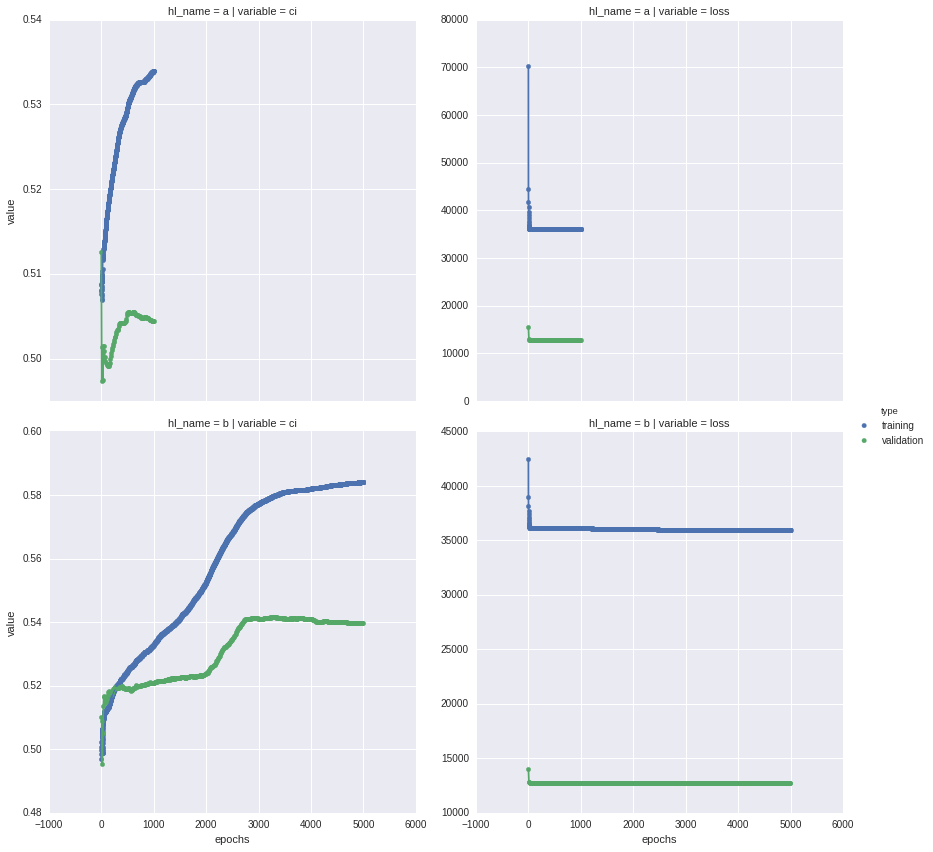

In [11]:
batch_norm = {
    "a": None,
    "b": True
}

all_stats = []
for name, hl in batch_norm.items():
    print name
    params = deepsurv_tf.Parameters()
    params.n_in = train['x'].shape[1]
    params.n_epochs = epochs
    params.batch_norm = hl
    
    ds_tf = deepsurv_tf.DeepSurvTF(params)
    stats = ds_tf.train(train, valid)
    
    stats = pandas.concat([pandas.DataFrame(i) for i in stats.values()]).reset_index(drop = True)
    stats = pandas.melt(stats, id_vars=["epochs","type"])
    stats["hl_name"] = name
    
    all_stats.append(stats)
    
stats = pandas.concat(all_stats)

sns.FacetGrid(data= stats,hue = "type", col="variable", row = "hl_name", sharey=False, size = 6) \
    .map(plt.plot, "epochs", "value") \
    .map(plt.scatter, "epochs", "value") \
    .add_legend()